In [1]:
# import dependencies
import io
import re
import nltk
import json
import gzip
import torch
import spacy
import string
import jsonlines
import pandas as pd
import pickle as pkl
import numpy as np
import mwparserfromhell
from torch.utils.data import Dataset
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# set file names for dumping pickle files and input data source
FILE_NAME = 'data/sample_1pct_wikitext.json'

PRETRAINED_EMBEDDINGS = 'pretrained-embeddings/wiki-news-300d-1M.vec'

OUTPUT_FILE = 'tokenized-data/wikitext_tokenized.p'
#OUTPUT_FILE_2 = 'tokenized-data/wikitext_tokenized_reduced.p'

WIKI_TRAIN_TOKENIZED_FILE = 'tokenized-data/wiki_train_tokenized.p'
WIKI_VALID_TOKENIZED_FILE = 'tokenized-data/wiki_valid_tokenized.p'
WIKI_TEST_TOKENIZED_FILE  = 'tokenized-data/wiki_test_tokenized.p'

MAX_ARTICLE_LENGTH = 500

# downloading and setting stop word list from NLTK
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peeyush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# clean text using regex - similar to what is used in FastText paper
def clean(text):
    text = text.lower()
    patterns = [
        "{{.*}}"
        ,"&amp;"
        ,"&lt;"
        ,"&gt;"
        ,"<ref[^<]*<\/ref>"
        ,"<[^>]*>"
        ,"\|left"
        ,"\|\d+px"
        ,"\[\[category:"
        ,r"(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b"
        ,"\|thumb"
        ,"\|right"
        ,"\[\[image:[^\[\]]*"
        ,"\[\[category:([^|\]]*)[^]]*\]\]"
        ,"\[\[[a-z\-]*:[^\]]*\]\]"
        ,"\["
        ,"\]"
        ,"\{[^\}]*\}"
        ,r"\n"
        ,r"[^a-zA-Z0-9 ]"
        ,r"\b[a-zA-Z]\b"
        ," +"
    ]
    
    for pattern in patterns:
        cleanr = re.compile(pattern)
        text = re.sub(cleanr, ' ', text)
    return text

# covert numerals to their text equivalent
def subsitute(text):
    return text.strip().replace('0', ' zero') \
                        .replace('1',' one') \
                        .replace('2',' two') \
                        .replace('3',' three') \
                        .replace('4',' four') \
                        .replace('5',' five') \
                        .replace('6',' six') \
                        .replace('7',' seven') \
                        .replace('8',' eight') \
                        .replace('9',' nine')

# remove empty token generated from inserting blank spaces
def remove_empty_token(tokens):
    result = []
    for token in tokens:
        if not token.strip() == '':
            result.append(token)
    return result

# optional - remove other common stop words 
# get the stop words from NLTK package
def remove_stop_words(tokens):
    result = []
    for token in tokens:
        if not token in STOP_WORDS:
            result.append(token)
    return result

# optional - remove words less than 3 character long
def remove_short_words(tokens):
    result = []
    for token in tokens:
        if len(token) >= 3:
            result.append(token)
    return result

# get the tokenized dataframe containing - QID, Word Tokens & Categories
def get_wiki_tokenized_dataset(file_name):
    wiki_dict = []
    with open(FILE_NAME) as file:
         for line in file:
            wiki_row = {}
            line = json.loads(line.strip())
            wikitext = mwparserfromhell.parse(line['wikitext'])
            wiki_row['QID'] = line['QID']
            wiki_row['mid_level_categories'] = line['mid_level_categories']
            wiki_row['tokens'] = tokenize(subsitute(clean(str(wikitext))))
            wiki_dict.append(wiki_row)

    wiki_df = pd.DataFrame(wiki_dict)
    wiki_df['tokens'] = wiki_df['tokens'].apply(remove_empty_token)
    return wiki_df

In [4]:
# #save the dataset in pickle file for subsequent use
# # Download the pickle files from Google Drive (else creating new will take ~4 hours)
# # https://drive.google.com/open?id=1DlNxxNh6WA5ds7px844LnBbhEzV0Ydyo
# wiki_df = get_wiki_tokenized_dataset(FILE_NAME)
# pkl.dump(wiki_df, open(OUTPUT_FILE, "wb"))

In [5]:
# load the dataframe from pickle file
wiki_df =  pkl.load(open(OUTPUT_FILE, "rb"))

In [6]:
wiki_df['tokens'] = wiki_df['tokens'].apply(remove_short_words)
wiki_df['tokens'] = wiki_df['tokens'].apply(remove_stop_words)

#### Data Exploration

In [7]:
a = pd.Series([word for article in wiki_df.tokens for word in article])
token_df = a.value_counts().sort_index().rename_axis('word').reset_index(name='count')

##### Word Distribution

In [9]:
tokens_freq_df = token_df[token_df['count'] > 5]
tokens_freq_df

,word,count
0,aaa,561
1,aaaa,41
2,aaaaa,9
15,aaaayaaj,6
22,aaai,10
...,...,...
694607,zytek,7
694623,zyx,15
694625,zyxin,8
694629,zyzzyva,7


##### Count Distribution

In [10]:
b = wiki_df['tokens'].apply(lambda x: len(x))

In [11]:
count_df = b.value_counts().sort_index().rename_axis('count').reset_index(name='frequency')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x16c57ef98>]],
      dtype=object)

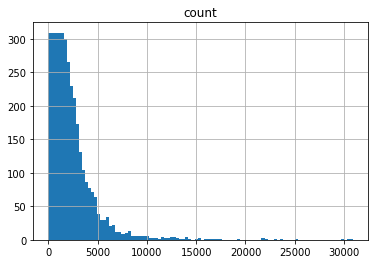

In [13]:
count_df.hist(column='count',bins=100)

#### OPTIONAL - Remove in-frequent tokens from corpus (words repeated less than 100 times) 

In [14]:
infrequent_tokens_df = token_df[token_df['count'] <= 5]
infrequent_tokens = infrequent_tokens_df['word'].tolist()
infrequent_tokens = set(infrequent_tokens)

In [15]:
# remove infrequent tokens
def remove_infrequent_words(tokens):
    result = [token for token in tokens if token not in infrequent_tokens]
    return result

wiki_df['tokens'] = wiki_df['tokens'].apply(remove_infrequent_words)

#### Split data into Train, Valid & Test

In [16]:
def train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [17]:
wiki_train, wiki_valid, wiki_test = train_validate_test_split(wiki_df)

#### Pretrained FASTText Embeddings

In [18]:
# load pre-trained fastText embeddings
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:]))).astype('float32')
    return data

# # Download from - https://drive.google.com/open?id=1vfoiWQkEjyNXRyi0JzA8Aq5Zzjfcpo2w
pretrained_embs = load_vectors(PRETRAINED_EMBEDDINGS)

In [19]:
# get all unique tokens in the training dataset
all_train_tokens = []

for tokens in wiki_train['tokens']:
    for token in tokens:
        all_train_tokens.append(token)
        
all_train_tokens = list(set(all_train_tokens))

In [20]:
# Analyse the wiki tokens and fastText embeddings
train_token_count = len(all_train_tokens)
token_in_fasttext = []
token_not_in_fasttext = []
train_token_in_fasttxt = 0

for token in all_train_tokens:
    if token in pretrained_embs.keys():
        token_in_fasttext.append(token)
        train_token_in_fasttxt = train_token_in_fasttxt + 1
    else:
        token_not_in_fasttext.append(token)

In [21]:
print("% of unique Wiki tokens in fASTText : {:4.2f}%".format(train_token_in_fasttxt/train_token_count*100))
print('unique tokens not in fastText :', len(token_not_in_fasttext))
print('unique tokens in fastText :', len(token_in_fasttext))

% of unique Wiki tokens in fASTText : 51.16%
unique tokens not in fastText : 74980
unique tokens in fastText : 78535


In [22]:
print("Sample tokens not in the fastText")
token_not_in_fasttext[:10]

Sample tokens not in the fastText


['avele',
 'radwan',
 'bagar',
 'iyashinai',
 'salviati',
 'sealdah',
 'pubnub',
 'shishmakov',
 'chamonix',
 'myrmicinae']

#### Running test to investigate which words are not in the embeddings

In [23]:
fasttext_dict = []
article_percentage = []
for idx, tokens in enumerate(wiki_train['tokens']):
    count = 0
    tokens_not_in_fasttext = []
    fasttext_row = {}
    for token in tokens:
        if token in pretrained_embs.keys():
            count = count + 1
        else :
            tokens_not_in_fasttext.append(token)
    
    if len(tokens) > 0:
        percent = count/len(tokens) * 100
    else:
        percent = 100
    
    article_percentage.append(percent)
    
    if percent < 75:
        fasttext_row['QID'] = wiki_train.iloc[idx]['QID'] 
        fasttext_row['Coverage'] = percent 
        fasttext_row['Tokens not in fastText'] = tokens_not_in_fasttext
        fasttext_row['Total Tokens'] = len(tokens)
        fasttext_dict.append(fasttext_row)
        
fasttext_df = pd.DataFrame(fasttext_dict)

In [24]:
fasttext_df = fasttext_df.sort_values(by=['Coverage','Total Tokens'])
fasttext_df
#fasttext_df.to_csv('fastText-analysis.csv', header=True)

,QID,Coverage,Tokens not in fastText,Total Tokens
1251,Q15947284,15.384615,"[darreh, bizhan, darreh, bizhan, olya, darreh,...",13
1428,Q6698784,17.647059,"[ludia, ludia, capuron, sleumer, sleumer, ludi...",68
195,Q4464501,21.777778,"[saprinus, histeridae, saprinus, saprinus, sap...",225
1284,Q2367080,22.222222,"[amblyptilia, pterophoridae, amblyptilia, ambl...",45
0,Q7607829,25.000000,"[stenoptilodes, pterophoridae, stenoptilodes, ...",36
...,...,...,...,...
1110,Q278582,74.782609,"[tyrol, tirol, tyrol, tyrol, tyrol, tyrol, tyr...",115
422,Q2957616,74.789916,"[nymphalidae, cajetan, felder, felder, indomal...",119
559,Q39091117,74.806202,"[actinocrinites, actinocrinites, actinocrinite...",258
131,Q14662980,74.809160,"[eutreta, tephritidae, eutreta, eutreta, eutre...",262


In [25]:
print("Average % of tokens coverage across articles in fastText :", sum(article_percentage)/len(wiki_train))

Average % of tokens coverage across articles in fastText : 94.34358723875535


In [26]:
with open(FILE_NAME) as file:
    for line in file:
        line = json.loads(line.strip())
        if line['QID'] == 'Q4464501':
            wiki_text = mwparserfromhell.parse(line['wikitext'])
            cleaned_text = subsitute(clean(str(wiki_text)))
            break

In [27]:
wiki_text

"{{Taxobox\n| name = ''Saprinus''\n| image = Histeridae - Saprinus ornatus.JPG\n| image_width = 250px\n| image_caption = ''[[Saprinus ornatus]]''\n| regnum = [[Animal]]ia\n| phylum = [[Arthropod]]a\n| classis = [[Insect]]a\n| ordo = [[Beetle|Coleoptera]]\n| superfamilia = [[Histeroidea]]\n| familia = [[Histeridae]]\n| subfamilia = [[Histerinae]]\n| genus = '''''Saprinus'''''\n| genus_authority =Erichson, 1834\n| synonyms =\n}}\n\n'''''Saprinus''''' is a genus of clown beetles belonging to the family [[Histeridae]].\n\n==Species==\n{{div col|colwidth=16em}}\n* ''[[Saprinus aberlenci]]''\n* ''[[Saprinus acuminatus]]''\n* ''[[Saprinus addendus]]''\n* ''[[Saprinus aegialius]]''\n* ''[[Saprinus aegyptiacus]]''\n* ''[[Saprinus aeneolus]]''\n* ''[[Saprinus aeneus]]''\n* ''[[Saprinus aequalis]]''\n* ''[[Saprinus aeratus]]''\n* ''[[Saprinus africanus]]''\n* ''[[Saprinus algericus]]''\n* ''[[Saprinus alienus]]''\n* ''[[Saprinus amethystinus]]''\n* ''[[Saprinus apteli]]''\n* ''[[Saprinus artensis

In [ ]:
cleaned_text

#### Build binarize output

In [28]:
# get all unique categories in the training dataset
all_categories = []

for categories in wiki_train.mid_level_categories:
    for category in categories:
        all_categories.append(category)
        
unique_categories = list(set(all_categories))

In [29]:
# set the multi-label binarizer on the categories and claims in the training dataset
multi_label_binarizer_categories = MultiLabelBinarizer(classes=unique_categories)

def binarize_target(result_df):
    result_df = result_df.join(pd.DataFrame(multi_label_binarizer_categories.fit_transform(result_df.pop('mid_level_categories')),
                          columns=multi_label_binarizer_categories.classes_,
                          index=result_df.index))
    return result_df

wiki_train = binarize_target(wiki_train)
wiki_valid = binarize_target(wiki_valid)
wiki_test = binarize_target(wiki_test)

In [30]:
wiki_train

,QID,tokens,Culture.Arts,STEM.Science,Culture.Performing arts,Geography.Oceania,Culture.Music,Culture.Crafts and hobbies,Culture.Plastic arts,STEM.Chemistry,...,STEM.Medicine,STEM.Technology,Culture.Internet culture,STEM.Information science,Geography.Americas,Culture.Games and toys,Geography.Maps,STEM.Engineering,STEM.Time,Culture.Food and drink
83696,Q25051720,"[mutual, combat, term, commonly, used, united,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51073,Q4660583,"[way, world, one, nine, nine, four, book, nobe...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7594,Q7341497,"[robert, ammann, october, one, one, nine, four...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24121,Q3177043,"[jennifer, crusie, born, one, nine, four, nine...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
35740,Q474397,"[tillon, communes, france, commune, ille, vila...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57669,Q6296457,"[journey, portugal, viagem, portugal, portugue...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23633,Q5518389,"[galena, park, isd, stadium, stadium, situated...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
102596,Q63345065,"[john, jackson, one, seven, eight, zero, one, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6228,Q1888467,"[southfleet, small, village, civil, parishes, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
